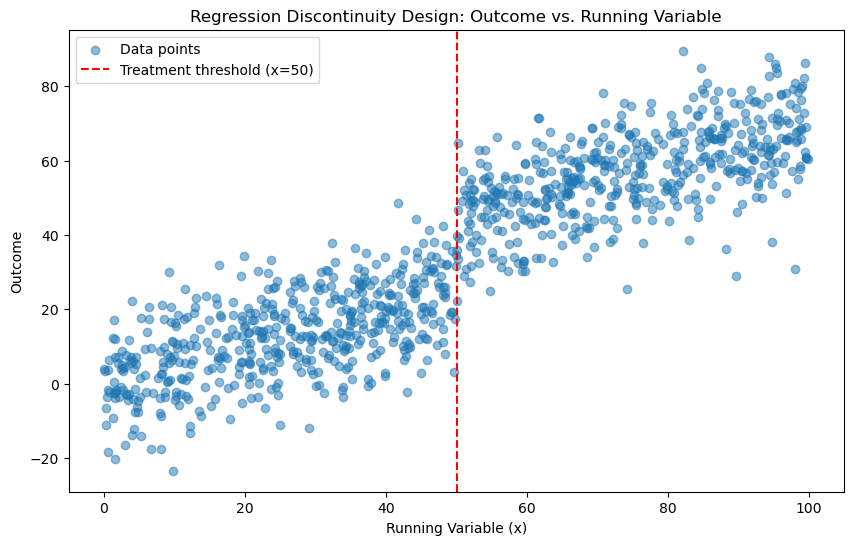

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     150.6
Date:                Sat, 08 Mar 2025   Prob (F-statistic):           6.77e-41
Time:                        19:32:21   Log-Likelihood:                -761.91
No. Observations:                 207   AIC:                             1530.
Df Residuals:                     204   BIC:                             1540.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.6042     10.792      0.612      0.5

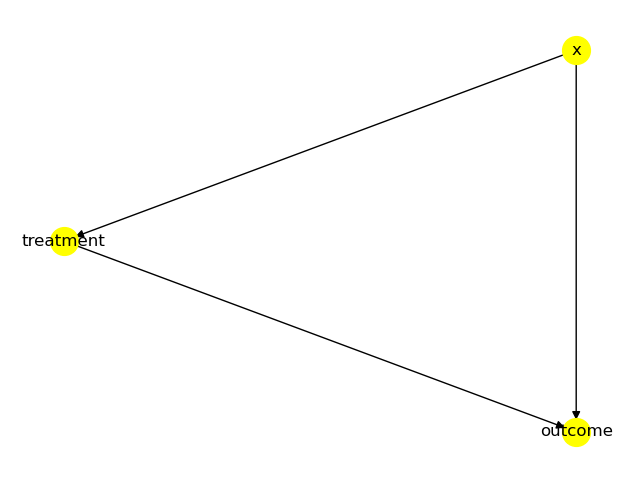

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import dowhy

# Set a random seed for reproducibility
np.random.seed(123)

# -----------------------------------------------------------------------------
# STEP 1: Simulate Synthetic Data for a Regression Discontinuity Design
# -----------------------------------------------------------------------------

# Generate a running variable 'x' uniformly distributed between 0 and 100.
# Here, the threshold is set at 50.
n = 1000
x = np.random.uniform(0, 100, n)

# Create a binary treatment indicator based on the cutoff at x = 50.
# If x is 50 or more, treatment=1; otherwise, treatment=0.
treatment = (x >= 50).astype(int)

# Simulate an outcome variable.
# Assume a base linear relationship with 'x' and add a discontinuity effect of 20 at the cutoff.
# Include random noise to mimic real-world data.
noise = np.random.normal(0, 10, n)
outcome = 0.5 * x + 20 * treatment + noise

# Combine into a pandas DataFrame.
df = pd.DataFrame({"x": x, "treatment": treatment, "outcome": outcome})

# -----------------------------------------------------------------------------
# STEP 2: Visualize the Discontinuity
# -----------------------------------------------------------------------------

# Plot the data to see the jump at the treatment threshold.
plt.figure(figsize=(10, 6))
plt.scatter(df["x"], df["outcome"], alpha=0.5, label='Data points')
plt.axvline(x=50, color='red', linestyle='--', label='Treatment threshold (x=50)')
plt.xlabel("Running Variable (x)")
plt.ylabel("Outcome")
plt.title("Regression Discontinuity Design: Outcome vs. Running Variable")
plt.legend()
plt.show()

# -----------------------------------------------------------------------------
# STEP 3: Focus on Data Around the Cutoff and Perform Local Linear Regression
# -----------------------------------------------------------------------------

# In an RD design, analysis is often restricted to a bandwidth around the cutoff.
# Here, we choose a bandwidth of 10 units on either side of 50.
bandwidth = 10
df_rd = df[(df["x"] >= 50 - bandwidth) & (df["x"] <= 50 + bandwidth)]

# Perform a local linear regression using statsmodels.
# The regression formula regresses outcome on the treatment indicator and the running variable.
model = smf.ols("outcome ~ treatment + x", data=df_rd).fit()
print(model.summary())

# -----------------------------------------------------------------------------
# STEP 4: Set Up and Analyze a Causal Model Using DoWhy
# -----------------------------------------------------------------------------

# Although regression discontinuity typically exploits a known cutoff, we can articulate
# a causal model using DoWhy by incorporating the running variable as a confounder.
#
# Define the causal model:
#   - Treatment: 'treatment'
#   - Outcome: 'outcome'
#   - Common cause: 'x' (the running variable which influences both treatment assignment and outcome)
model_dowhy = dowhy.CausalModel(
    data=df_rd,
    treatment='treatment',
    outcome='outcome',
    common_causes=['x']
)

# Visualize the causal graph (this will open a PDF file if running locally).
model_dowhy.view_model()

# Identify the causal effect using DoWhy’s identification algorithms.
identified_estimand = model_dowhy.identify_effect()
print("Identified estimand:")
print(identified_estimand)

# Estimate the causal effect using a linear regression method.
estimate = model_dowhy.estimate_effect(identified_estimand,
                                       method_name="backdoor.linear_regression")
print("Causal Effect Estimate:", estimate.value)

# -----------------------------------------------------------------------------
# STEP 5: Refutation – Check the Robustness of the Causal Estimate
# -----------------------------------------------------------------------------

# Refute the obtained estimate using a placebo treatment test.
refute_placebo = model_dowhy.refute_estimate(identified_estimand, estimate,
                                             method_name="placebo_treatment_refuter")
print(refute_placebo)


---

### 1. OLS Regression Results
- **Overall Model Fit:**
  - R-squared of about 0.596 tells us that roughly 60% of the variation in the outcome is explained by the running variable and the treatment indicator. Think of it like a car’s dashboard showing 60% of the factors affecting fuel efficiency are captured by your current gauges.

- **Interpreting the Coefficients:**
  - **Intercept (≈ 6.60):**  
    - This is the estimated outcome when both treatment = 0 and x = 0. In our context, the intercept is less important because our focus is on the change at the cutoff.
  - **Treatment (≈ 19.70, p-value ≈ 0.000):**  
    - This coefficient means that when you cross the threshold (from x < 50 to x ≥ 50), the outcome jumps, on average, by about 19.7 units.  
    - The very low p-value (close to zero) tells us that this jump is highly statistically significant—not likely due to random chance.  
    - **Analogy:** Imagine you are watching a traffic light that changes from red to green. The moment it turns green, cars start moving—and here, “moving” is our outcome increasing sharply by about 20 units.
  - **Running Variable (x) (≈ 0.36, p-value ≈ 0.14):**  
    - While this coefficient reflects the general trend of x on the outcome, its high p-value means the effect isn’t statistically significant within this narrow bandwidth.  
    - **Analogy:** Think of x as the gradual slope of a hill—but at a critical point (x = 50), there’s a jump (the treatment) that makes the difference. The slope itself is present but not the main driver of the dramatic change.

### 2. DoWhy Causal Model Results
- **Identified Estimand:**
  - DoWhy confirms that, under the backdoor adjustment (i.e., controlling for the running variable x), the average causal effect (Nonparametric ATE) is identifiable.  
  - The expressed estimand essentially tells us that we’re comparing the expected outcomes right around the threshold, adjusting for x.
  - The fact that alternative estimands (like IV or frontdoor) were not applicable here confirms that the backdoor criterion (adjusting for x) was the right choice for this RD design.

- **Causal Effect Estimate:**
  - The causal effect estimate from DoWhy is 19.6971, matching the treatment coefficient from the OLS regression.  
  - In simple terms, crossing the threshold (being "treated") causes the outcome to increase by about 19.7 units on average.

### 3. Refutation Using a Placebo Treatment
- **Placebo Treatment Test:**
  - This step intentionally assigns a “fake” treatment to check whether the observed effect could be spurious.
  - The result of this test shows a new effect of only about 0.04 with a very high p-value (≈ 0.90), meaning that when you use a placebo, no significant effect is detected.
  - **Analogy:** Imagine you suspect that a secret ingredient makes a cake taste sweeter. You test a cake with a random ingredient (placebo) instead. If the cake’s sweetness doesn’t change, you can be more confident that your secret ingredient (the actual treatment) is truly responsible for the sweetness boost.  
  - In our case, the placebo effect being nearly zero reinforces that the original treatment effect of approximately 19.7 is genuine and not due to noise or mis-specification.

### Summary
- A clear and statistically significant jump of ~19.7 units in the outcome occurs at the cutoff, supporting the presence of a treatment — much like a sudden shift in behavior at a clearly defined boundary.
- The running variable (x) isn’t significantly driving the outcome change within the selected bandwidth, emphasizing that the discontinuity (and thus the treatment effect) is the main causal driver.
- The DoWhy causal framework confirms the estimated effect and the robustness refutation test (with a placebo treatment) adds further confidence: when we use an artificial treatment, no effect is observed. This reassures us that the effect of 19.7 is due to the treatment assignment at the threshold rather than some hidden bias.

---
